<a href="https://colab.research.google.com/github/gvnbleid/2020-GUM/blob/maciek-branch/MGU_Projekt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integracja z Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
BASE_DIR = '/content/gdrive/My Drive/DL2020/Projekt2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Sieć konwolucyjna

## Konfiguracja wstępna

In [0]:
%matplotlib inline

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import time
import copy

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cuda not available")
print(device)

cuda:0


In [0]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

## Konfiguracja sieci

In [0]:
#@title Wybór konfiguracji { run: "auto" }

config = "Pretrained VGG16" #@param ["Adventures in Machine Learning", "PyTorch tutorial", "Wzbogacony LeNet-5", "Wlasna konfiguracja 1", "Pretrained VGG16"]

In [7]:
last_epoch = 0
last_loss = None

class Net(nn.Module):
    if config == "PyTorch tutorial":
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    elif config == "Adventures in Machine Learning":
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(32, 64, 5)
            self.fc1 = nn.Linear(64 * 5 * 5, 1000)
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 64 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.softmax(self.fc2(x), dim=0)
            return x

    elif config == "Wzbogacony LeNet-5":
        def __init__(self):
            super(Net, self).__init__()

            self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, stride = 1, kernel_size = 3, padding = 1)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, stride = 1, kernel_size = 3, padding = 1)
            self.relu2 = nn.ReLU()
            self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, stride = 1, kernel_size = 3, padding = 0)
            self.relu3 = nn.ReLU()
            self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.linear1 = nn.Linear(7 * 7 * 32, 300)
            self.relu4 = nn.ReLU()
            self.drop1 = nn.Dropout(p = 0.5)
            self.linear2 = nn.Linear(300, 10)

            self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2,
                                 self.maxpool1, self.conv3, self.relu3, self.maxpool2)
                                             
        def forward(self, x):
            x = self.net(x)
            x = x.view(-1, x.shape[0] , 7 * 7 * 32)
            x = self.linear1(x)
            x = self.relu4(x)
            x = self.drop1(x)
            x = self.linear2(x)
            return x

    elif config == "Wlasna konfiguracja 1":
        def __init__(self):
            super(Net, self).__init__()

            self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, stride = 1, kernel_size = 3, padding = 1)
            self.batchnorm1 = nn.BatchNorm2d(num_features = 16)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, stride = 1, kernel_size = 3, padding = 1)
            self.batchnorm2 = nn.BatchNorm2d(num_features = 32)
            self.relu2 = nn.ReLU()
            self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, stride = 1, kernel_size = 3, padding = 0)
            self.batchnorm3 = nn.BatchNorm2d(num_features = 64)
            self.relu3 = nn.ReLU()
            self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.linear1 = nn.Linear(7 * 7 * 64, 300)
            self.relu4 = nn.ReLU()
            self.drop1 = nn.Dropout(p = 0.5)
            self.linear2 = nn.Linear(300, 10)
            self.net = nn.Sequential(self.conv1, self.batchnorm1, self.relu1, self.conv2, self.batchnorm2, self.relu2,
                                 self.maxpool2, self.conv3, self.batchnorm3, self.relu3, self.maxpool3)
                                             
        def forward(self, x):
            x = self.net(x)
            x = x.view(-1, x.shape[0] , 7 * 7 * 64)
            x = self.linear1(x)
            x = self.relu4(x)
            x = self.drop1(x)
            x = self.linear2(x)
            return x

net = None
input_size = 32

if config == "Pretrained VGG16":
    def set_parameter_requires_grad(model):
        for param in model.parameters():
            param.requires_grad = False

    net = models.vgg16_bn(pretrained=True)
    set_parameter_requires_grad(net)
    num_ftrs = net.classifier[6].in_features
    net.classifier[6] = nn.Linear(num_ftrs, 10)
    net = net.to(device)
    input_size = 224
else:
    net = Net().to(device)

net

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

params_to_update = []
for param in net.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

### Wczytanie stanu sieci (opcjonalne)

In [0]:
load_state = False #@param {type: "boolean"}
path = "" #@param {type: "string"}

if load_state:
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    criterion.load_state_dict(checkpoint['criterion_state_dict'])
    last_epoch = checkpoint['epoch']
    last_loss = checkpoint['loss']

    model.eval()

## Ustawienia augmentacji danych

In [0]:
#@title Metody augmentacji { run: "auto" }
translation_checkbox = False #@param {type:"boolean"}
flip_checkbox = False #@param {type:"boolean"}
rotation_checkbox = False #@param {type:"boolean"}
noise_checkbox = False #@param {type:"boolean"}

In [0]:
transforms_array = []

transforms_array.append(transforms.Resize(input_size))

if translation_checkbox:
    transforms_array.append(transforms.RandomAffine(0, (0.2, 0.2)))
if flip_checkbox:
    transforms_array.append(transforms.RandomHorizontalFlip())
if rotation_checkbox:
    transforms_array.append(transforms.RandomRotation(30))

transforms_array.append(transforms.ToTensor())
transforms_array.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]))

if noise_checkbox:
    transforms_array.append(AddGaussianNoise(0., 0.2))

## Wczytanie danych

In [14]:
transform = transforms.Compose(transforms_array)
test_transform = transforms.Compose([
                                     transforms.Resize(input_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225]
                                     )
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer horse  bird horse   car horse truck   cat horse  deer


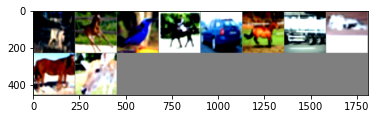

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

## Uczenie sieci - funkcja

In [0]:
nb_epoch = 10 #@param {type: "integer"}

In [18]:
def train_net(net, dataloaders, criterion, optimizer, nb_epoch, last_epoch):
    since = time.time()

    test_acc_array = []
    train_acc_array = []
    best_net = copy.deepcopy(net.state_dict())
    best_acc = 0.0

    for epoch in range(nb_epoch):  # loop over the dataset multiple times
        last_epoch = last_epoch + 1

        for phase in ['train', 'test']:
            if phase == 'train':
                net.train()
                dataloader = dataloaders[0]
            else:
                net.eval()
                dataloader = dataloaders[1]
        
            running_loss = 0.0
            running_correct = 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # forward + backward + optimize
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)

                    _, prediction = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # print statistics
                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(prediction == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_correct.double() / len(dataloader.dataset)

            print('Epoch %s/%s - %s Loss: %.3f Acc: %.3f' %
                (epoch + 1, nb_epoch, phase, epoch_loss, epoch_acc))
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_net = copy.deepcopy(net.state_dict())
            if phase == 'test':
                test_acc_array.append(epoch_acc)
            else:
                train_acc_array.append(epoch_acc)
    
    training_time = time.time() - since
    print('Finished Training in %.0fm %.0fs' % (training_time // 60, training_time % 60))
    print('Best test Accuracy: %.3f' % (best_acc))

    net.load_state_dict(best_net)
    return net, test_acc_array, train_acc_array

net, test_acc_array, train_acc_array = train_net(net, [trainloader, testloader], criterion, optimizer, nb_epoch, last_epoch)

Epoch 1/10 - train Loss: 0.927 Acc: 0.679
Epoch 1/10 - test Loss: 0.676 Acc: 0.766
Epoch 2/10 - train Loss: 0.873 Acc: 0.700
Epoch 2/10 - test Loss: 0.643 Acc: 0.780
Epoch 3/10 - train Loss: 0.873 Acc: 0.701
Epoch 3/10 - test Loss: 0.636 Acc: 0.780
Epoch 4/10 - train Loss: 0.863 Acc: 0.708
Epoch 4/10 - test Loss: 0.623 Acc: 0.782
Epoch 5/10 - train Loss: 0.861 Acc: 0.708
Epoch 5/10 - test Loss: 0.612 Acc: 0.786
Epoch 6/10 - train Loss: 0.865 Acc: 0.709
Epoch 6/10 - test Loss: 0.625 Acc: 0.779
Epoch 7/10 - train Loss: 0.861 Acc: 0.709
Epoch 7/10 - test Loss: 0.612 Acc: 0.788
Epoch 8/10 - train Loss: 0.871 Acc: 0.705
Epoch 8/10 - test Loss: 0.613 Acc: 0.787
Epoch 9/10 - train Loss: 0.858 Acc: 0.710
Epoch 9/10 - test Loss: 0.605 Acc: 0.788
Epoch 10/10 - train Loss: 0.857 Acc: 0.712
Epoch 10/10 - test Loss: 0.630 Acc: 0.783
Finished Training in 41m 23s
Best test Accuracy: 0.788


## Uczenie sieci (kod Maćka)

In [0]:
nb_epoch = 10 #@param {type: "integer"}
loss_array = []

for epoch in range(nb_epoch):  # loop over the dataset multiple times

    last_epoch = last_epoch + 1
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        net.train()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            last_loss = running_loss / 2000
            print('[%d, %5d] loss: %.3f' %
                (last_epoch, i + 1, last_loss))
            
            loss_array.append(last_loss)

            running_loss = 0.0
print('Finished Training')

## Uczenie sieci (kod Jacka)

In [0]:
nb_epoch = 6 #@param {type: "integer"}
loss_array = []

optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay=0)

for epoch in range(nb_epoch):  # loop over the dataset multiple times

    last_epoch = last_epoch + 1
    running_loss = 0.0

    for i, (img, label) in enumerate(trainloader):
        img = img.to(device)
        label = label.to(device)
        net.train()
        optimizer.zero_grad()
        prediction = net(img)
        loss = criterion(prediction[0], label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            last_loss = running_loss / 2000
            print('[%d, %5d] loss: %.3f' %
                (last_epoch, i + 1, last_loss))
            
            loss_array.append(last_loss)

            running_loss = 0.0
print('Finished Training')

[11,  2000] loss: 0.630
[11,  4000] loss: 0.657
[12,  2000] loss: 0.619
[12,  4000] loss: 0.630
[13,  2000] loss: 0.588
[13,  4000] loss: 0.611
[14,  2000] loss: 0.554
[14,  4000] loss: 0.593
[15,  2000] loss: 0.541
[15,  4000] loss: 0.590
[16,  2000] loss: 0.533
[16,  4000] loss: 0.555
Finished Training


### Zapis stanu modelu (opcjonalne)

In [0]:
from datetime import datetime

def append_timestamp(path):
    now = datetime.now()
    current_time = now.strftime("%y.%m.%d_%H:%M:%S")
    return path.replace(".", f"_{current_time}.")

In [0]:
save_state = True #@param {type: "boolean"}
path = "vgg.pt" #@param {type: "string"}
use_timestamp = True #@param {type: "boolean"}

if save_state:
    if use_timestamp:
        path = append_timestamp(path)
    torch.save({
                'epoch': last_epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'criterion_state_dict': criterion.state_dict(),
                'test_acc': test_acc_array,
                'train_acc': train_acc_array
                }, BASE_DIR + path)

## Wyniki (kod Maćka)

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * accuracy))

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

accuracy_per_class = []

for i in range(10):
    accuracy_per_class.append({
                               'class': classes[i], 
                               'accuracy': class_correct[i] / class_total[i]
                               })
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

## Wyniki (kod Maćka + kod Jacka)

In [0]:
def update_classify_table(classify_table, predictions, labels):
        for lab, pred in zip(labels, predictions):
            classify_table[lab, pred] += 1

In [22]:
correct = 0
total = 0
loss = 0.0
with torch.no_grad():
    net.eval()
    classify_table = np.zeros((10,10))
    for i, (img, label) in enumerate(testloader):
        img = img.to(device)
        label = label.to(device)
        prediction = net(img)
        loss += criterion(prediction, label)
        _ , prediction = torch.max(prediction.data, 1)
        update_classify_table(classify_table, prediction, label.data)
        correct += torch.sum(prediction == label.data)

accuracy = correct.cpu().numpy() / 10000
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * accuracy))

Accuracy of the network on the 10000 test images: 78 %


## Wyniki (kod Jacka)

In [0]:
def update_classify_table(classify_table, predictions, labels):
        for lab, pred in zip(labels, predictions):
            classify_table[lab, pred] += 1

In [0]:
correct = 0
total = 0
loss = 0.0
with torch.no_grad():
    net.eval()
    classify_table = np.zeros((10,10))
    for i, (img, label) in enumerate(testloader):
        img = img.to(device)
        label = label.to(device)
        prediction = net(img)
        loss += criterion(prediction[0], label)
        _ , prediction = torch.max(prediction[0].data, 1)
        update_classify_table(classify_table, prediction, label.data)
        correct += torch.sum(prediction == label.data)

accuracy = correct.cpu().numpy() / 10000
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * accuracy))

Accuracy of the network on the 10000 test images: 71 %


### Zapis wyników (opcjonalne)

In [0]:
save_results_state = True #@param {type: "boolean"}
use_timestamp = True #@param {type: "boolean"}
path = "pytorch_tutorial.json" #@param {type: "string"}

from datetime import datetime
import json
import codecs

if save_results_state:
    if use_timestamp:
        path = append_timestamp(path)

    json.dump(dict(accuracy=accuracy, accuracy_per_class=accuracy_per_class),
              codecs.open(BASE_DIR + path, 'w', encoding='utf-8'))

## Wykresy

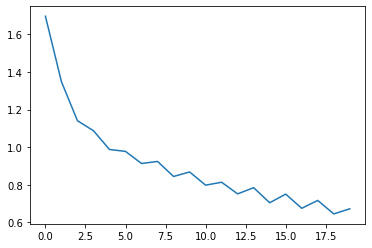

In [0]:
import matplotlib.pyplot as plt

plt.plot(loss_array)

In [0]:
import copy

classes = ['samolot', 'samochód', 'ptak', 'kot', 'jeleń', 'pies', 'żaba', 'koń', 'statek', 'ciężarówka']

def visualise_accuracy_by_class(classify_table):
    #indices = np.arange(10)
    results = [ classify_table[i,i] / np.sum(classify_table[i, :]) for i in range(10)]
    plt.bar(classes, results, color = ['#7e57c2', '#ffc400'])
    plt.title("Frakcja poprawnych klasyfikacji dla poszczególnych klas")
    plt.xlabel('Klasa')
    plt.ylabel('Frakcja poprawnych klasyfikacji')
    plt.xticks(classes, rotation='vertical')
    plt.show()
    
def visualise_errors_by_class(classify_table):
    #indices = np.arange(10)
    p = list()
    table = copy.deepcopy(classify_table)
    table[np.argmax(table, 0), np.argmax(table, 1)] = 0
    p.append(plt.bar(classes, table[:, 0]))
    for i in range(1, 10):
        p.append(plt.bar(classes, table[:, i], bottom = np.sum(table[:, 0:i], 1)))
    plt.title("Błędy klasyfikacji")
    plt.xticks(classes, rotation='vertical')
    plt.xlabel("Poprawna klasa")
    plt.ylabel("Liczba błędnych klasyfikacji")
    plt.legend(classes, title = "Klasa zwracana przez sieć", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

def visualise_errors_for_class(classify_table, class_index):
    #indices = np.arange(10)
    p = list()
    table = copy.deepcopy(classify_table)
    table[np.argmax(table, 0), np.argmax(table, 1)] = 0
    plt.bar(classes, table[:, class_index])
    plt.xticks(classes, rotation='vertical')
    plt.title("Liczba błędnych klasyfikacji dla klasy: {}".format(class_index))
    plt.xlabel("Klasa zwracana przez sieć")
    plt.ylabel("Liczba błędnych klasyfikacji")
    plt.show()

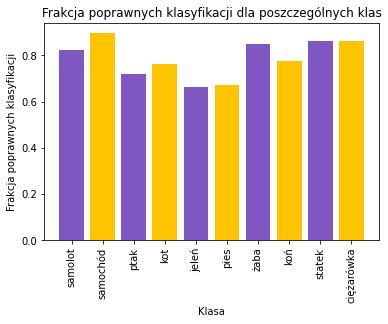

In [34]:
visualise_accuracy_by_class(classify_table)

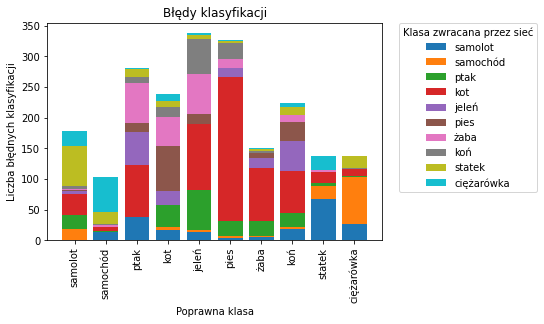

In [38]:
visualise_errors_by_class(classify_table)

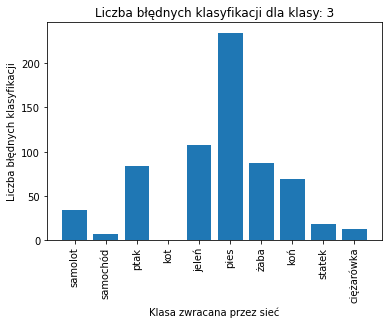

In [36]:
visualise_errors_for_class(classify_table, 3)